In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
data_path = 'round-1-island-data-bottle'
files = sorted(os.listdir(data_path))
files = [f for f in files if f.endswith('.csv')]

In [16]:
prices = []
for file in files[:3]:
    prices.append(pd.read_csv(os.path.join(data_path, file), sep = ';'))
prices = pd.concat(prices, axis=0)



In [14]:
map_symbol = {
    'ame' : 'AMETHYSTS',
    'sta' : 'STARFRUIT',
}

In [17]:
prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,AMETHYSTS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,STARFRUIT,5045,1,5040.0,31.0,NaN,NaN,5047,31,NaN,NaN,NaN,NaN,5046.0,0.0
2,-1,100,STARFRUIT,5040,24,NaN,NaN,NaN,NaN,5046,2,5047.0,22.0,NaN,NaN,5043.0,0.0
3,-1,100,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
4,-1,200,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0


In [24]:
def get_trades(symbol):
    trades = []
    for file in files[3:]:
        temp = pd.read_csv(os.path.join(data_path, file), sep = ';')
        temp = temp[temp['symbol'] == map_symbol[symbol]]
        temp = temp.set_index('timestamp')
        trades.append(temp)
    return trades

def get_prices(symbol):
    global temp
    prices = []
    for file in files[:3]:
        temp = pd.read_csv(os.path.join(data_path, file), sep = ';')
        temp = temp[temp['product'] == map_symbol[symbol]]
        temp = temp.set_index('timestamp')
        prices.append(temp)
    return prices

In [33]:
sta_trades = get_trades('sta')
sta_prices = get_prices('sta')

In [204]:
bid_vol_cols = [col for col in sta_prices[0].columns if 'bid_volume' in col]
ask_vol_cols = [col for col in sta_prices[0].columns if 'ask_volume' in col]

bid_price_cols = [col for col in sta_prices[0].columns if 'bid_price' in col]
ask_price_cols = [col for col in sta_prices[0].columns if 'ask_price' in col]

In [328]:
def get_day(n):
    global temp
    temp = sta_prices[n]
    temp['bid_volume'] = temp[bid_vol_cols].sum(axis=1)
    temp['ask_volume'] = temp[ask_vol_cols].sum(axis=1)
    
    # temp['bid_weighted'] = temp['bid_price_1']
    # temp['ask_weighted'] = temp['ask_price_1']
    
    temp['bid_weighted'] = temp.fillna(0).apply(
        lambda x: sum(x[f'bid_price_{i}'] * x[f'bid_volume_{i}'] for i in range(1, 4))/x['bid_volume'], axis=1)
    temp['ask_weighted'] = temp.fillna(0).apply(
        lambda x: sum(x[f'ask_price_{i}'] * x[f'ask_volume_{i}'] for i in range(1, 4))/x['ask_volume'], axis=1)

    # temp['bid_weighted'] = temp[bid_price_cols].min(axis=1)
    # temp['ask_weighted'] = temp[ask_price_cols].max(axis=1)
    
    mid_prices = (temp['bid_weighted'] + temp['ask_weighted'])/2

    return mid_prices, temp

def get_reg_data():
    data = []
    
    for i in range(3):
        df, _ = get_day(i)
        temp = pd.concat([
            df.shift(-1), df, df.shift(1), df.shift(2), df.shift(3), df.shift(4), df.shift(5), df.shift(6), df.shift(7), df.shift(8)
        ], axis=1)
        data.append(temp)
    res = pd.concat(data, axis=0)
    return res
    
data = get_reg_data()

In [329]:
train = data.iloc[:-10000]
test = data.iloc[-10000:]

In [342]:
df = data
model = sm.OLS(df[0], sm.add_constant(df.iloc[:, 1:]), missing = 'drop').fit()
# model = sm.OLS(df[0], df.iloc[:, 1:], missing = 'drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.076e+07
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:45:37   Log-Likelihood:                -25567.
No. Observations:               29973   AIC:                         5.115e+04
Df Residuals:                   29963   BIC:                         5.124e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6952      0.512      1.358      0.174      -0.308       1.699
1              0.7190      0.006    124.467      0.000       0.708       0.730
2              0.1998      0.007     28.083      0.000       0.186       0.214
3              0.0510      0.007      7.080      0.000       0.037       0.065
4              0.0228      0.007      3.167      0.002       0.009       0.037
5              0.0145      0.007      2.004      0.045       0.000       0.029
6             -0.0114      0.007     -1.574      0.115      -0.025       0.003
7              0.0100      0.007      1.383      0.167      -0.004       0.024
8             -0.0121      0.007     -1.706      0.088      -0.026       0.002
9              0.0063      0.006      1.092      0.275      -0.005       0.018
==============================================================================
Omnibus:                      245.536   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.340
Skew:                          -0.025   Prob(JB):                     1.05e-85
Kurtosis:                       3.557   Cond. No.                     2.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [343]:
model.params.to_list()[::-1]

[0.006305986347540827,
 -0.01214216608632497,
 0.009966507857309953,
 -0.011357179548720021,
 0.0144586905386713,
 0.022841418289938183,
 0.05102468136008776,
 0.19978102347281332,
 0.7189835095609063,
 0.6951698609096012]

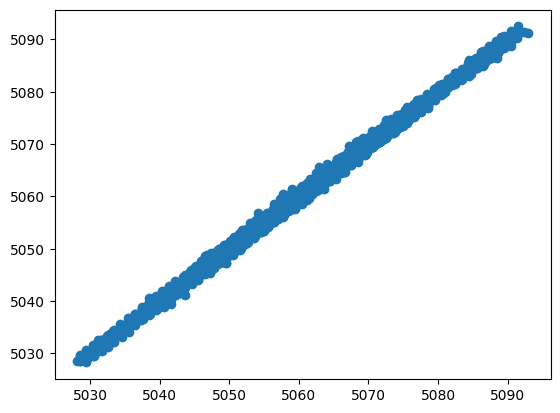

In [321]:
df = test
add = False

x = df.iloc[:, 1:]
if add:
    x = sm.add_constant(x)

pred = model.predict(x)
plt.scatter(df[0], pred)

In [275]:
df[0]

timestamp
0         5039.5
100       5040.0
200       5040.5
300       5040.5
400       5040.5
           ...  
999500    5050.5
999600    5051.5
999700    5050.5
999800    5050.5
999900       NaN
Name: 0, Length: 10000, dtype: float64

In [230]:
a = sorted([(100, -2), (103, -4), (105, -6)])
b = sorted([(99, 2), (97, 4), (95, 6)], key = lambda x: -x[0])
b

[(99, 2), (97, 4), (95, 6)]

In [231]:
def best_price(order_dict, buy=0):
    tot_vol = 0
    best_val = -1
    max_vol = -1

    for price, vol in order_dict:
        if buy == 0:
            vol *= -1
        tot_vol += vol
        if tot_vol > max_vol:
            max_vol = vol
            best_val = price
        
        print(tot_vol, max_vol, best_val)

    return best_val

In [229]:
best_price(a)

2 2 100
6 4 103
12 6 105


105

In [232]:
best_price(b, 1)

2 2 99
6 4 97
12 6 95


95